In [1]:
import cv2
import skimage.io
import numpy as np
import tkinter as tk
from tkinter import *
from helpers import *
from functions import *
from matplotlib import pyplot as plt
from tkinter import filedialog as fd
from tkinter import messagebox as mb


def loadConfig(fname):
    config = loadPickle(fname)
    for key in config.keys():
        globals()[str(key)] = config[key]
    globals()['configFile'] = fname
    
try:
    loadConfig('config.pkl')
except:
    print("Failed to load the config file!")
    quit()

In [2]:
class hemisphere:
    def __init__(self, fname):
        

        self.backProjectedVector = None
        self.normalizationVector = None
        
        self.coeff_layers = None
        self.index_layers = None
        
        self.size = None
        self.backProject = None
        self.scalingFactor = None
        
#         self.backProjectedVector = None
#         self.normalizationVector = None

#         self.coeff_layers = None
#         self.index_layers = None

#         self.size = None
        
        try:
            self.loadLayers(fname)
        except:
            print("Could not find previously saved layers, Please make sure to initlaize them!")

    def loadLayers(self, fname):
        self.coeff_layers, self.index_layers, self.scalingFactor = loadPickle(fname)
        self.size = np.array(self.coeff_layers[0].shape, dtype='int32')
        
    def createNormalizationImage(self):
        self.backProjectedVector = np.zeros(self.size).astype(numpy_types[types['BAKC_PROJECTED']]).ravel()
        ones = np.ones(numFields).astype(numpy_types[types['RESULTS']])
        for i in range(len(self.coeff_layers)):
            backProject(ones,  self.coeff_layers[i],  self.index_layers[i],  self.backProjectedVector)
        self.normalizationVector = np.copy(self.backProjectedVector)
        self.normalizationVector[np.where(self.normalizationVector==0)]=1
        
    def backProject(self, sampledVector):
        zeros_int32(self.backProjectedVector)
        for i in range(len(self.coeff_layers)):
            backProject(sampledVector,  self.coeff_layers[i],  self.index_layers[i],  self.backProjectedVector)
        normalize(self.backProjectedVector, self.normalizationVector)

In [3]:
class cortex:
    def __init__(self, leftPath, rightPath):
        self.left_hemi = hemisphere(leftPath)
        for i in range(len(self.left_hemi.coeff_layers)):
            self.left_hemi.coeff_layers[i] = np.rot90(self.left_hemi.coeff_layers[i],1).ravel()
            self.left_hemi.index_layers[i] = np.rot90(self.left_hemi.index_layers[i],1).ravel()
        self.left_hemi.createNormalizationImage()

        self.right_hemi = hemisphere(rightPath)
        for i in range(len(self.right_hemi.coeff_layers)):
            self.right_hemi.coeff_layers[i] = np.rot90(self.right_hemi.coeff_layers[i],-1).ravel()
            self.right_hemi.index_layers[i] = np.rot90(self.right_hemi.index_layers[i],-1).ravel()
        self.right_hemi.createNormalizationImage()
        
    def backProject_gray(self, sampledVector):
        self.left_hemi.backProject(sampledVector)
        self.right_hemi.backProject(sampledVector)

In [4]:
C = cortex('left_path.pkl', 'right_path.pkl')

In [5]:
def get_backProjected(hemisphere, figsize=(16,9)):
    w = hemisphere.size[0]
    h = hemisphere.size[1]
    return hemisphere.backProjectedVector[:h*w].reshape((h,w))

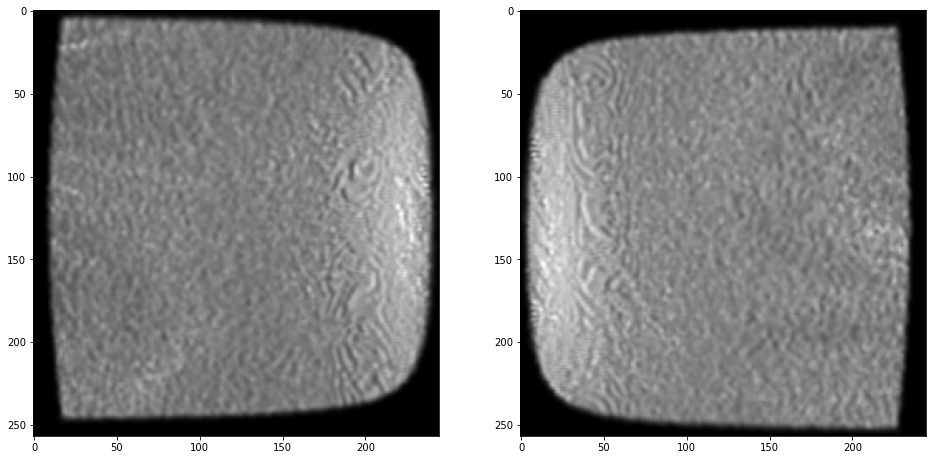

In [6]:
normL = get_backProjected(C.left_hemi)
normR = get_backProjected(C.right_hemi)

fig,a = plt.subplots(1,2,figsize=(16,9))
a[0].imshow(normL, cmap='gray')
a[1].imshow(normR, cmap='gray')
plt.show()